In [1]:
import pandas as pd 
import tensorflow as tf
import torch
% pip install sentencepiece
!pip install transformers

     |████████████████████████████████| 1.2MB 7.3MB/s 
     |████████████████████████████████| 2.3MB 7.5MB/s 
     |████████████████████████████████| 901kB 35.2MB/s 
     |████████████████████████████████| 3.3MB 51.4MB/s 


In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
#importing the data
tsv_read = pd.read_csv("train.tsv", sep='\t')
df = tsv_read

#splitting train and test data 
n = len(df)
n_train = int(n*0.8)
df_train = df[0:n_train]


print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))



Number of training sentences: 124,848



In [5]:
phrases = df_train.Phrase.values
labels = df_train.Sentiment.values
print(phrases)

['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'
 'A series of escapades demonstrating the adage that what is good for the goose'
 'A series' ...
 "proves once again that he 's the best brush in the business"
 "once again that he 's the best brush in the business"
 "that he 's the best brush in the business"]


In [6]:
#importing xlnet tokenizers
import transformers
from transformers import XLNetTokenizer
from transformers import XLNetModel, XLNetForSequenceClassification


#XLnet tokenzier (lower case)
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
print(type(tokenizer))



<class 'transformers.models.xlnet.tokenization_xlnet.XLNetTokenizer'>


In [7]:
# tokenizing sentences and map token to IDs
input_ids = []

for phrase in phrases:
    encoded_phrase = tokenizer.encode(
                        phrase,                      
                        add_special_tokens = True, #adding  CLS and SEP
                   )
    
    #appending the enconded phrases to input_ids list
    input_ids.append(encoded_phrase)

In [8]:
#finding maximum sentence length
max_train = max([len(phrase) for phrase in input_ids])
print(max_train)

98


In [9]:
#padding the sequences so they have the same length
max_length = 35


#importing pad_squences
from keras.preprocessing.sequence import pad_sequences

#padding with value 0 at end of sequence
input_ids = pad_sequences(input_ids, maxlen=max_length, dtype="long", 
                          value=0, truncating="post", padding="post")

In [10]:
#creating attention masks

#initialising attention_masks
att_masks = []
for phrase in input_ids:
    #for non-zero token IDs, set mask to 1
    masks = [int(token_id > 0) for token_id in phrase]    
    # appending to attention_masks
    att_masks.append(masks)

In [11]:
#splitting data train and validation
#importing train_test_split 
from sklearn.model_selection import train_test_split
#80% train, 20% validation
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=1, test_size=0.2)
#same split for masks
train_masks, validation_masks, _, _ = train_test_split(att_masks, labels,
                                             random_state=1, test_size=0.2)

In [12]:
#converting into torch tensors (type = long) 
train_inputs = torch.tensor(train_inputs,  dtype=torch.long)
validation_inputs = torch.tensor(validation_inputs,  dtype=torch.long)
train_labels = torch.tensor(train_labels,  dtype=torch.long)
validation_labels = torch.tensor(validation_labels,  dtype=torch.long)
train_masks = torch.tensor(train_masks,  dtype=torch.long)
validation_masks = torch.tensor(validation_masks,  dtype=torch.long)

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#setting batch size to 64
batch_size = 64
#creating dataloader for training data
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
#creating dataloader for validation data
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [14]:
from transformers import AdamW

model2 = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased',
                                                        num_labels = 5)
#to run on GPU
model2.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [15]:
#using AdamW optimiser to fine-tune the model
optimizer = AdamW(model2.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )
from transformers import get_linear_schedule_with_warmup
#number of training epochs
epochs = 4
#total steps 
total_steps = len(train_dataloader) * epochs
#creating learning rate schedule
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [16]:
import numpy as np

#calculating accuracy by averaging the correctly classified obs over the number of labels
def accuracy_score(predictions, labels):
    pred = np.argmax(predictions, axis=1).flatten()
    labs = labels.flatten()
    return np.sum(predictions == labs) / len(labs)

In [17]:
#Training

import random
#setting sed to 1
seed_val = 1
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
#torch.cuda.manual_seed_all(seed_val)
#initialising average loss at each epoch.
loss_values = []
for i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(i + 1, epochs))

    #resetting total loss
    total_loss = 0
    model2.train()
    for step, batch in enumerate(train_dataloader):
        #updating training loss
        if step % 10 == 0 and not step == 0:          
            #reporting progress
            print(f"batch number {step} of {len(train_dataloader)}")
       
        batch_input_ids = batch[0].to(device)
        batch_input_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)
        model2.zero_grad()        
        #Forward pass to return the loss
        outputs = model2(batch_input_ids, 
                    token_type_ids=None, 
                    attention_mask=batch_input_mask, 
                    labels=batch_labels)
        
        #retrieving loss value
        loss = outputs[0]
        #calculating average loss over all batches
        total_loss += loss.item()


        #backward pass to calculate gradients
        loss.backward()
        #clipping gradients to 1 to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        #updating parameters
        optimizer.step()
        #updating learning rate
        scheduler.step()
    #calculating average loss over all the training data
    avg_train_loss = total_loss / len(train_dataloader)            
    
    #appending avg_train_loss to loss_values
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))


======== Epoch 1 / 4 ========
batch number 10 of 1561
batch number 20 of 1561
batch number 30 of 1561
batch number 40 of 1561
batch number 50 of 1561
batch number 60 of 1561
batch number 70 of 1561
batch number 80 of 1561
batch number 90 of 1561
batch number 100 of 1561
batch number 110 of 1561
batch number 120 of 1561
batch number 130 of 1561
batch number 140 of 1561
batch number 150 of 1561
batch number 160 of 1561
batch number 170 of 1561
batch number 180 of 1561
batch number 190 of 1561
batch number 200 of 1561
batch number 210 of 1561
batch number 220 of 1561
batch number 230 of 1561
batch number 240 of 1561
batch number 250 of 1561
batch number 260 of 1561
batch number 270 of 1561
batch number 280 of 1561
batch number 290 of 1561
batch number 300 of 1561
batch number 310 of 1561
batch number 320 of 1561
batch number 330 of 1561
batch number 340 of 1561
batch number 350 of 1561
batch number 360 of 1561
batch number 370 of 1561
batch number 380 of 1561
batch number 390 of 1561
bat

In [18]:
    #Validation

    model2.eval()
    #Initialising variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    val_accuracy = []
  

    for batch in validation_dataloader:
        
        #adding to GPU
        batch = tuple(t.to(device) for t in batch)
        #batch = tuple(batch)
        
        # retrieving inputs from dataloader
        batch_input_ids, batch_input_mask, batch_labels = batch
        with torch.no_grad():        
            #Forward pass to calculate logit predicitions (output values before
            #applying activation function)
            outputs = model2(batch_input_ids, 
                            token_type_ids=None, 
                            attention_mask=batch_input_mask)
        #retrieveing logits
        logits = outputs[0]
        #Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()
        
        # Calculating accuracy per batcg
        accuracy_batch = accuracy_score(logits, label_ids)
        
        # Accumulate the total accuracy.
        #eval_accuracy += tmp_eval_accuracy
        val_accuracy.append(accuracy_batch)
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(sum(val_accuracy)/nb_eval_steps))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


  Accuracy: 0.00


In [19]:
#performance on test set

df_test = df[n_train+1:n]
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))

#Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))
#creating phrases and label lists
phrases = df_test.Phrase.values
labels = df_test.Sentiment.values
# tokenizing to map to input_ids
input_ids = []
for phrase in phrases:
    encoded_phrase = tokenizer.encode(
                        phrase,                      
                        add_special_tokens = True,
                   )
    
    input_ids.append(encoded_phrase)
#padding tokens
input_ids = pad_sequences(input_ids, maxlen=max_length, 
                          dtype="long", truncating="post", padding="post")
#creating attention masks
att_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  att_masks.append(seq_mask) 
#converting everything to tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(att_masks)
prediction_labels = torch.tensor(labels)
#setting batch size to 64
batch_size = 64  
#creating the dataloader
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of training sentences: 124,848

Number of test sentences: 31,211



In [20]:
# Prediction on test set
model2.eval()
#initialising variables
predictions , true_labels = [], []
#prediciting
for batch in prediction_dataloader:
  #adding to GPU
  batch = tuple(t.to(device) for t in batch)
  #batch = tuple(batch)
  
  #retrieve inputs from dataloader
  batch_input_ids, batch_input_mask, batch_labels = batch
  with torch.no_grad():
      # Forward pass to calculate logit predicitions
      outputs = model2(batch_input_ids, token_type_ids=None, 
                      attention_mask=batch_input_mask)
  logits = outputs[0]
  #moving logits to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = batch_labels.to('cpu').numpy()
  
  #appending logits and b_labels to predcictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [21]:
import torch.nn.functional as F
# Concatenate logits from each batch
cat_logits = np.concatenate(predictions)

# Apply softmax to calculate probabilities
probs = F.softmax(torch.tensor(cat_logits), dim=1).numpy()
#print(probs[0:10])

max_list = probs.max(axis=1)
max_index = probs.argmax(axis=1)
print(max_list)
print(max_index)

[0.67249763 0.71896416 0.67897016 ... 0.8075787  0.5788995  0.8534233 ]
[3 3 3 ... 2 3 2]


In [22]:
true_labels = df_test.Sentiment
predicted_labels = max_index

correct_labels = sum(true_labels == predicted_labels)/len(predicted_labels)*100
print(correct_labels)

66.43491076863927


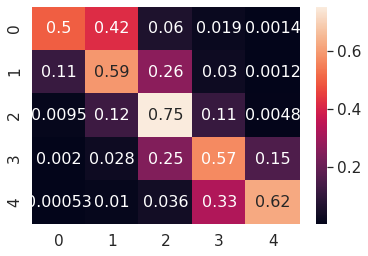

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

cm_xlnet = confusion_matrix(true_labels, predicted_labels, normalize='true')
cm_xlnet_unnorm = confusion_matrix(true_labels, predicted_labels)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_xlnet = pd.DataFrame(cm_xlnet, range(5), range(5))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_xlnet, annot=True, annot_kws={"size": 16}) # font size
plt.show()

In [24]:
# Accuracy, recall and precision

accuracy=sum(np.diag(cm_xlnet_unnorm))/np.sum(cm_xlnet_unnorm)
print("Accuracy is", accuracy*100, "%")

recall = np.zeros(5)
precision = np.zeros(5)
for i in range(5):
  recall[i] = round((cm_xlnet_unnorm[i, i] / np.sum(cm_xlnet_unnorm[:, i])) * 100, 2)
  precision[i] = round((cm_xlnet_unnorm[i, i] / np.sum(cm_xlnet_unnorm[i, :])) * 100, 2)

recall = pd.DataFrame(recall)
precision = pd.DataFrame(precision)
eval = pd.concat([recall, precision], axis = 1)
eval.columns = ['Recall (%)', 'Precision (%)']
print(eval)

Accuracy is 66.43491076863927 %
   Recall (%)  Precision (%)
0       46.48          49.90
1       56.77          59.40
2       77.66          75.26
3       59.72          56.97
4       51.51          62.40


In [25]:
df['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [26]:
print(cm_xlnet_unnorm)


[[  720   607    87    27     2]
 [  669  3515  1552   175     7]
 [  146  1864 11562  1716    74]
 [   13   187  1619  3763  1023]
 [    1    19    68   620  1175]]


In [ ]:
#testing model on unseen input

#new_input = "insert unseen input sentence here"
new_input = "The movie was ok but I didn't like the actors"

# tokenizing to map to input_ids
input_id = tokenizer.encode(
                        new_input,                      
                        add_special_tokens = True)
input_id = np.array(input_id)
input_id = np.reshape(input_id, (1, -1))
#padding tokens
input_id = pad_sequences(input_id, maxlen=max_length, 
                          dtype="long", truncating="post", padding="post")
#creating attention masks
att_masks = []
# Create a mask of 1s for each token followed by 0s for padding
att_masks = [float(i>0) for i in input_id[0, :]] 
#converting everything to tensors
prediction_input = torch.tensor(input_id)
prediction_masks = torch.tensor(att_masks)
prediction_masks = torch.reshape(prediction_masks, (1, 35))

# predicting label for unseen input
prediction_input = prediction_input.to(device)
prediction_masks = prediction_masks.to(device)
model2 = model2.to(device)
outputs = model2(prediction_input, token_type_ids=None, 
                      attention_mask=prediction_masks)
predicition_logits = outputs[0]


#softmax through logit
import torch.nn.functional as F

# Apply softmax to calculate probabilities

probs = F.softmax(torch.tensor(predicition_logits), dim=1)
probs = probs.cpu()
probs = probs.numpy()

max_list = probs.max(axis=1)
max_index = probs.argmax(axis=1)

print(f"Sentiment prediction of unseen input is {max_index}")